# Parte II

### Carga de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import backend as K
import keras
from time import time

Using TensorFlow backend.


 ### a. Carga de datos y normalización

Se cargan los datos, y se definen los distintos conjuntos de entrenamiento, pruebas y validación.

In [2]:
datos = pd.read_csv('EnergyMolecule/roboBohr.csv')

In [3]:
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)

In [4]:
n_test=0

In [5]:
def init_data():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    total = len(datos)
    perc_60 = int(total * 0.6)
    perc_85 = int(total * 0.85)    
    df_train = datos[:perc_60]
    df_val = datos[perc_60:perc_85]
    df_test = datos[perc_85:]
    scaler = StandardScaler().fit(df_train)
    X_train_scaled = pd.DataFrame(
        scaler.transform(df_train), columns=df_train.columns)
    X_val_scaled = pd.DataFrame(
        scaler.transform(df_val), columns=df_val.columns)
    X_test_scaled = pd.DataFrame(
        scaler.transform(df_test), columns=df_test.columns)
    y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1, 1)
    y_val_scaled = X_val_scaled.pop('Eat').values.reshape(-1, 1)
    X_test_scaled.drop(columns=['Eat'], axis=1, inplace=True)
init_data()

### Funciones comunes

In [6]:
def plot_gradients(gradients, layer):
    n2=len(gradients)
    ne2=np.arange(n2)
    grd=gradients.reshape(-1)
    plt.bar(ne2,grd)
    plt.grid()
    plt.title('Gradiente por neurona en la capa '+str(layer+1))
    plt.xlabel('Neurona')
    plt.ylabel('Gradiente')
    plt.show()

In [7]:
def plot_chart(history):
    plt.rcParams["figure.figsize"] = [12,4]
    subtitle=''
    global n_test
    var_activation=''
    train_loss=history.history['loss']
    test_loss=history.history['val_loss']
    plt.subplot(1,2,1)
    plt.plot(train_loss)
    plt.plot(test_loss)
    n_test=n_test+1
    plt.title('MODEL LOSS, test #'+str(n_test)+'\n'+
              str.capitalize(var_activation)+', '+subtitle)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    min_v=0
    max_v=np.max(train_loss)
    plt.title('TRAIN VS TEST, test #'+str(n_test)+'\n'+
              str.capitalize(var_activation)+', '+subtitle)
    plt.xlabel('train')
    plt.ylabel('test')
    plt.grid()
    plt.plot([0,max_v], [0,max_v], color='red', linewidth=0.5)
    plt.scatter(train_loss,test_loss)
    plt.xlim(0,max_v)
    plt.ylim(0,max_v)
    plt.show()

In [8]:
def train_model(model):
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    config = tf.ConfigProto()
    history = model.fit(
        X_train_scaled,
        y_train_scaled,
        epochs=250,
        verbose=0,
        validation_data=(X_val_scaled, y_val_scaled))
    return (history)

In [9]:
def calculate_gradients(model):
    global evaluated_gradients
    loss = keras.losses.mean_squared_error(model.output, y_train_scaled)
    listOfVariableTensors = model.trainable_weights
    gradients = K.gradients(loss, listOfVariableTensors)
    sess = K.get_session()
    evaluated_gradients = sess.run(
        gradients, feed_dict={model.input: X_train_scaled.values})
    evaluated_gradients = [
        gradient / len(y_train_scaled) for gradient in evaluated_gradients
    ]
    history = train_model(model)
    return(history)

### b. Generación de la red y entrenamiento

Se pudo comprobar que el ejercicio despues del entrenamiento hay un mejor ajuste del modelo.

In [10]:
def define_model_b():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform', activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

----- Antes del entrenamiento

In [11]:
model_b = define_model_b()
history_b = train_model(model_b)

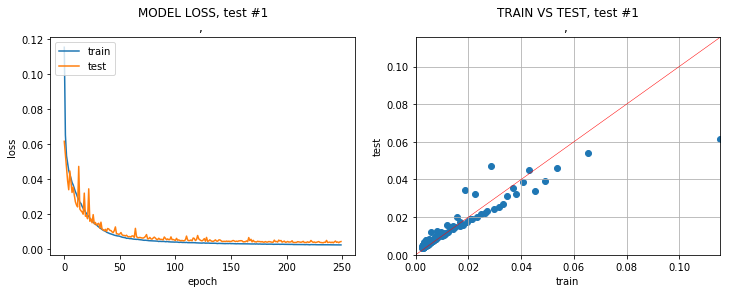

In [12]:
plot_chart(history_b)

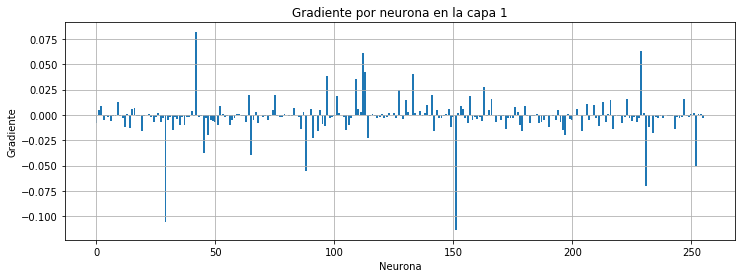

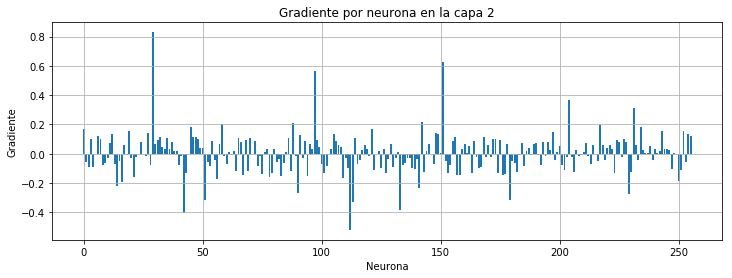

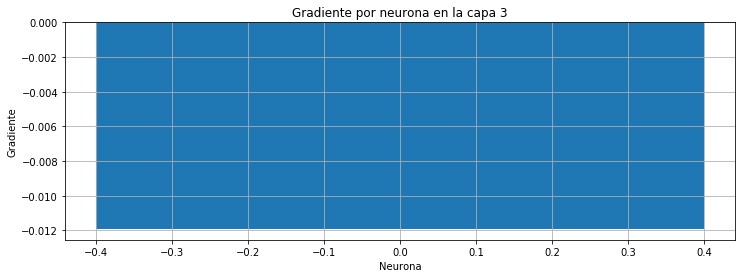

In [13]:
plot_gradients(model_b.get_weights()[1],0)
plot_gradients(model_b.get_weights()[2],1)
plot_gradients(model_b.get_weights()[3],2)

----- Después del entrenamiento

In [14]:
model_b2 = define_model_b()

In [15]:
history_b2=calculate_gradients(model_b2)

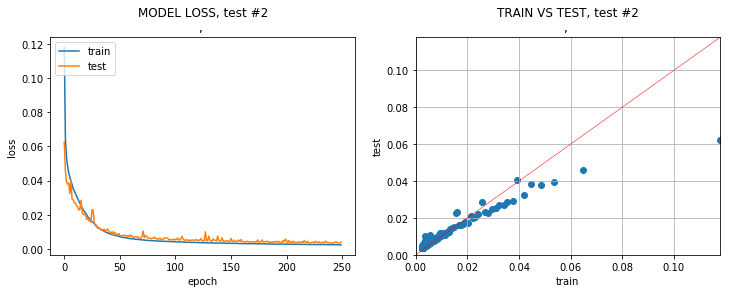

In [16]:
plot_chart(history_b2)

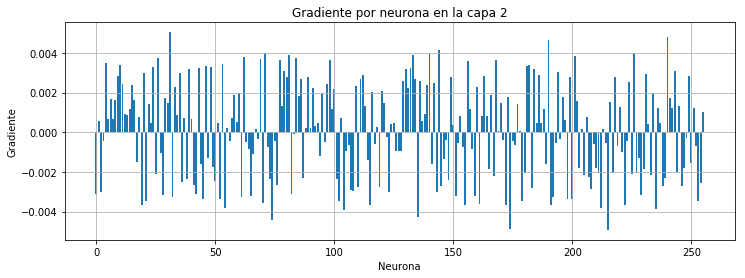

In [17]:
plot_gradients(evaluated_gradients[1],1)

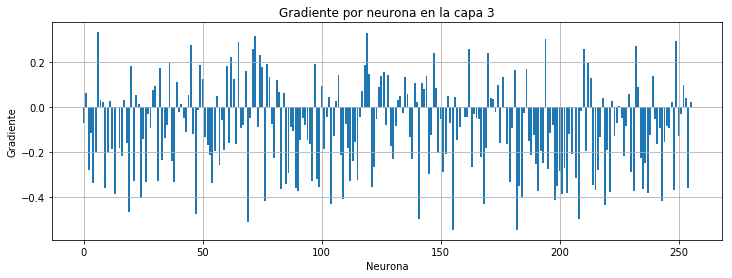

In [18]:
plot_gradients(evaluated_gradients[2],2)

### c. Red de 6 capas

Se puede evidenciar que en el ejercicio es claramente visible la diferencia que se produce en el entrenamiento despues de los 150 epochs, adicionalmente se ve considerablemente el efecto de la disminuciòn del gradiente en las distintas capas.

In [20]:
def define_model_c():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform', activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

In [21]:
model_c = define_model_c()
history_c = calculate_gradients(model_c)

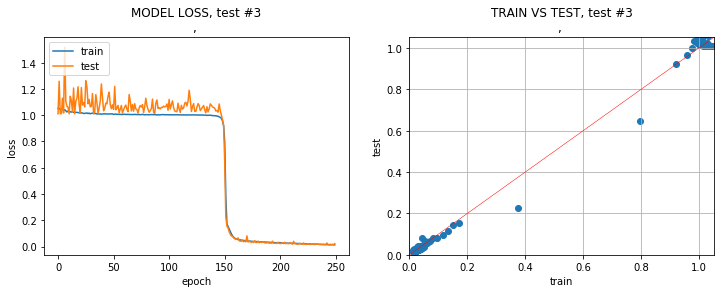

In [23]:
plot_chart(history_c)

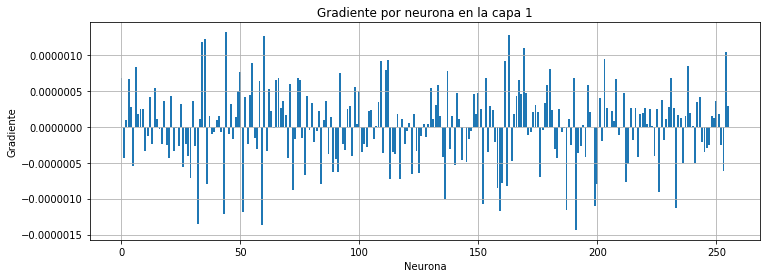

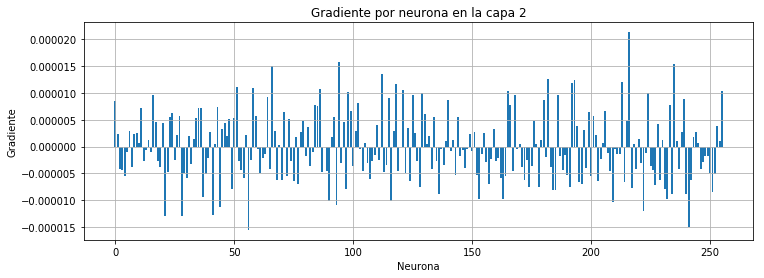

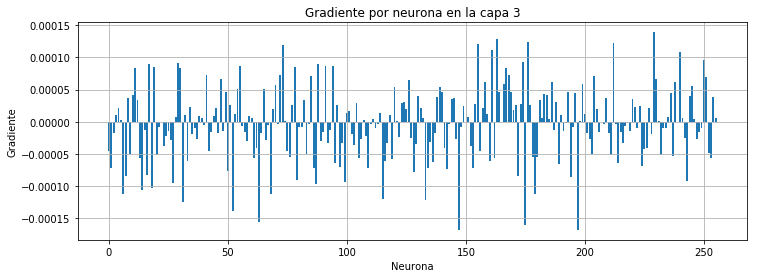

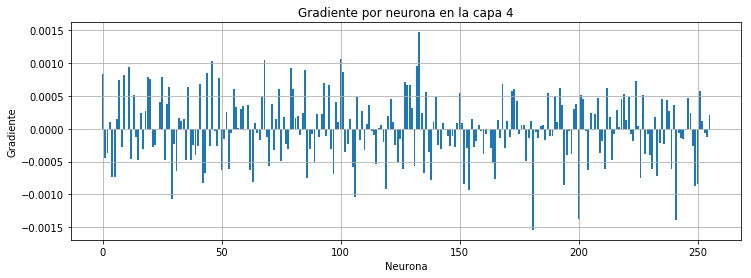

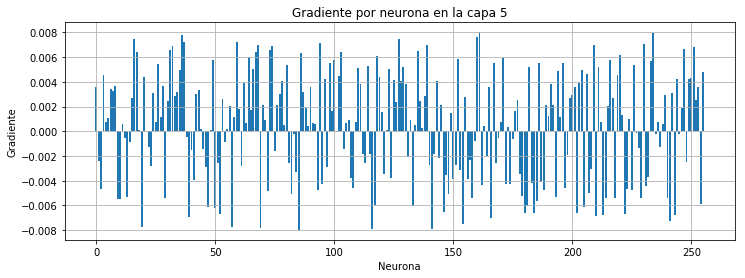

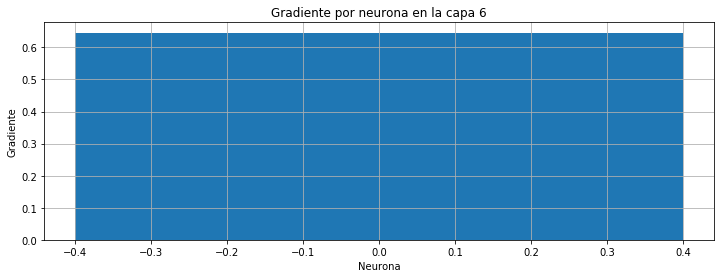

In [24]:
plot_gradients(evaluated_gradients[1],0)
plot_gradients(evaluated_gradients[3],1)
plot_gradients(evaluated_gradients[5],2)
plot_gradients(evaluated_gradients[7],3)
plot_gradients(evaluated_gradients[9],4)
plot_gradients(evaluated_gradients[11],5)

### d. Red con inicializador Glorot

Al utilizar la  inicializacion con Glorot Uniforme, se puede observar una mejora respecto al caso anterior, debido a que la convergencia se logra mucho antes.

In [25]:
def define_model_d():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='glorot_uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='glorot_uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='glorot_uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='glorot_uniform',
            activation='sigmoid'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='glorot_uniform',
            activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='glorot_uniform', activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

In [26]:
model_d = define_model_d()
history_d = calculate_gradients(model_d)

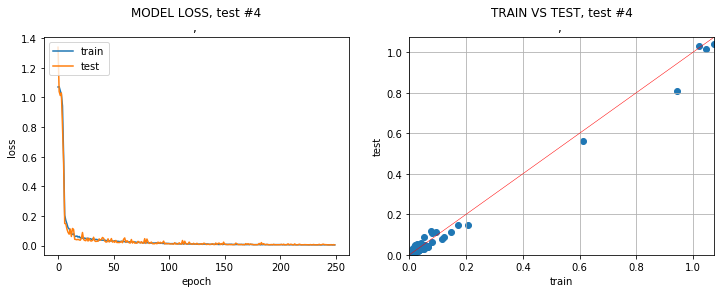

In [27]:
plot_chart(history_d)

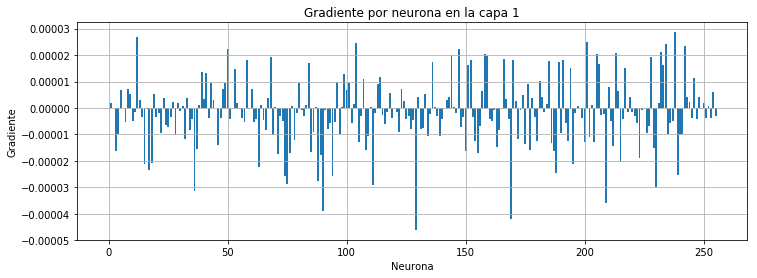

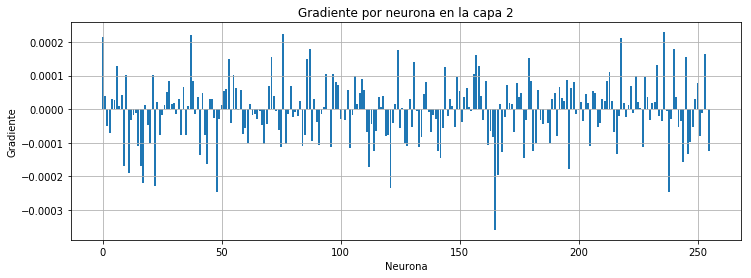

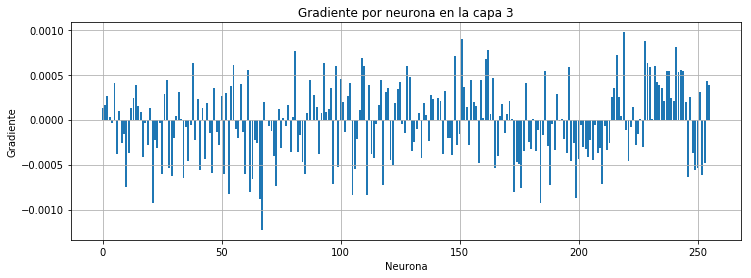

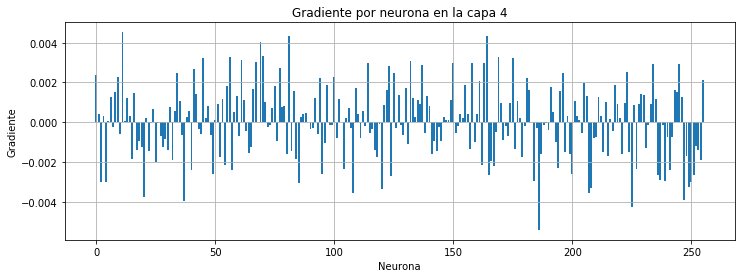

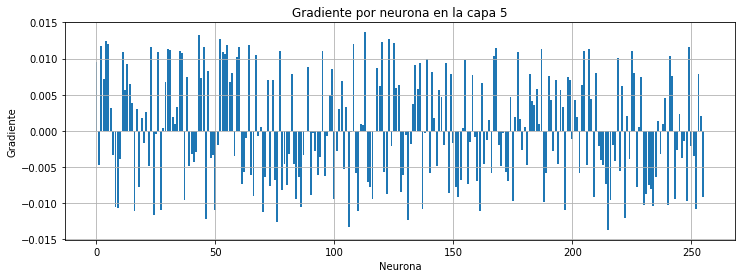

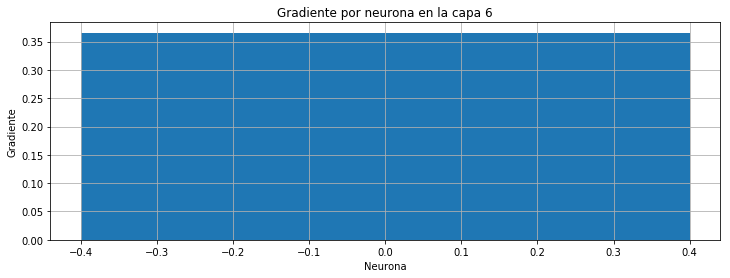

In [29]:
plot_gradients(evaluated_gradients[1],0)
plot_gradients(evaluated_gradients[3],1)
plot_gradients(evaluated_gradients[5],2)
plot_gradients(evaluated_gradients[7],3)
plot_gradients(evaluated_gradients[9],4)
plot_gradients(evaluated_gradients[11],5)

### e. Relu, Uniforme y He

----- Relu, Uniforme

En el ejercicio se ve de manifiesto el efecto de la inicialiazciòn uniforme sobre la funciòn de activación ReLU. Prueba de la importancia del buen uso de la combinación es que la misma función con inicialización he_uniform genero NaNs en la medicion de perdida.

In [30]:
def define_model_e1():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

In [31]:
model_e1 = define_model_e1()
history_e1 = calculate_gradients(model_e1)

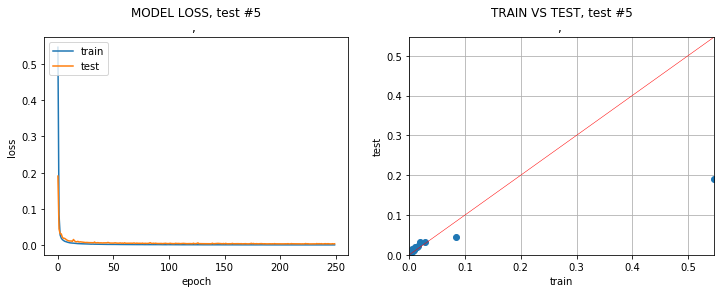

In [32]:
plot_chart(history_e1)

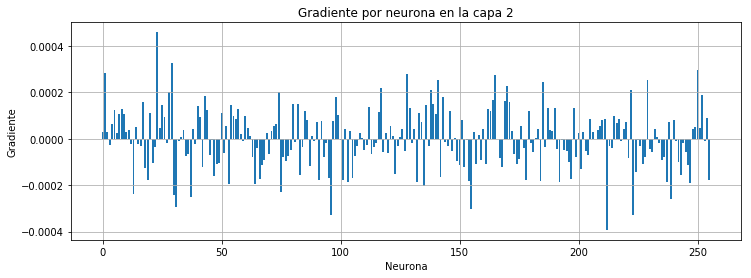

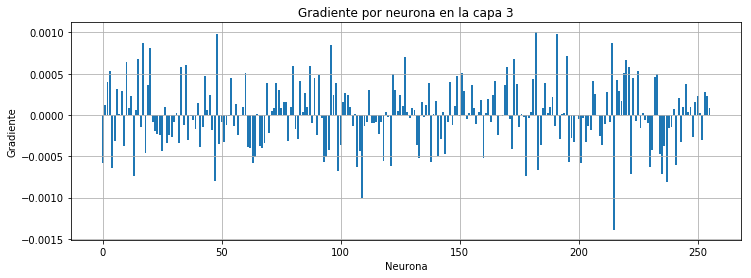

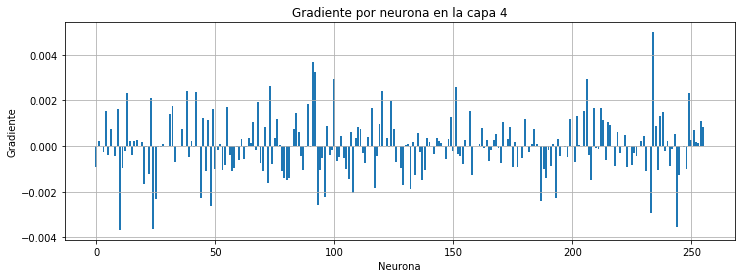

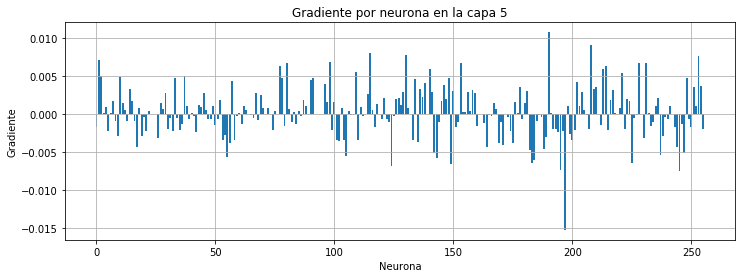

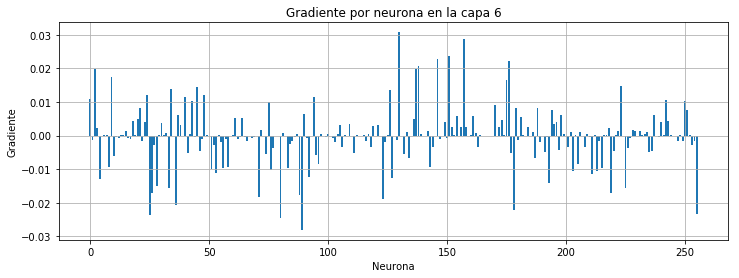

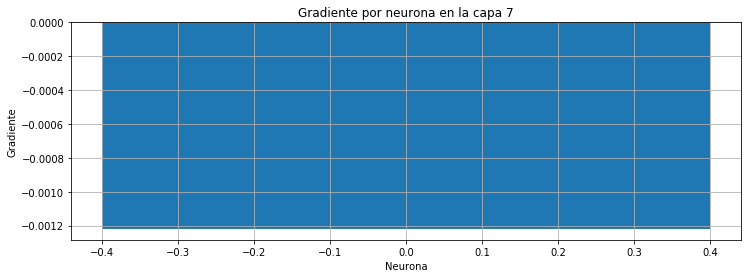

In [33]:
plot_gradients(evaluated_gradients[1],1)
plot_gradients(evaluated_gradients[3],2)
plot_gradients(evaluated_gradients[5],3)
plot_gradients(evaluated_gradients[7],4)
plot_gradients(evaluated_gradients[9],5)
plot_gradients(evaluated_gradients[11],6)

----- Relu, He uniforme

In [34]:
def define_model_e2():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='relu'))
    model.add(Dense(1, kernel_initializer='he_uniform', activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

In [35]:
model_e2 = define_model_e2()
history_e2 = calculate_gradients(model_e2)

/home/rohermosilla/.conda/envs/redesneuronales/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: Axis limits cannot be NaN or Inf

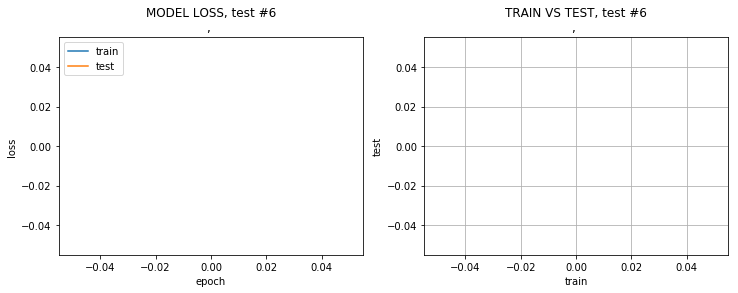

In [37]:
plot_chart(history_e2)

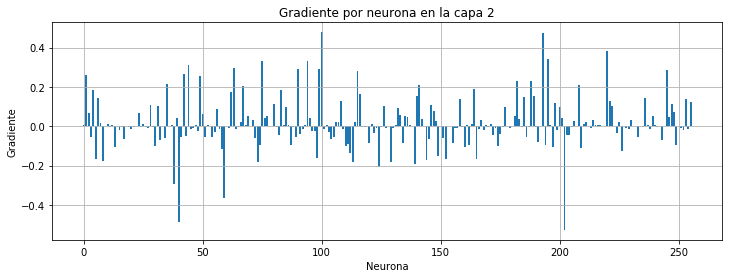

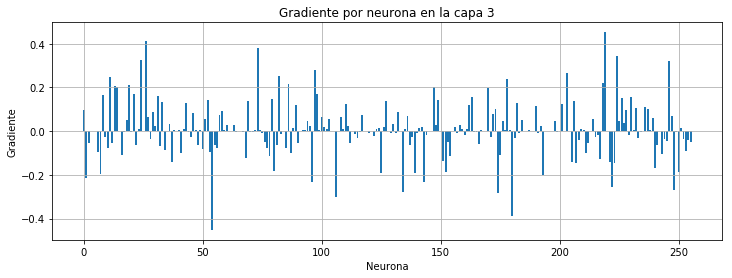

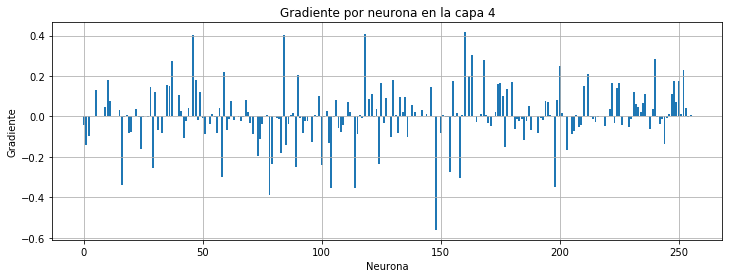

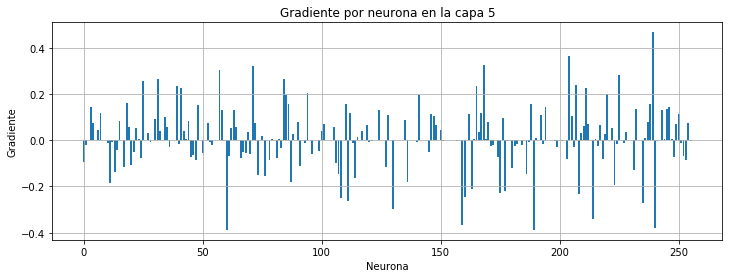

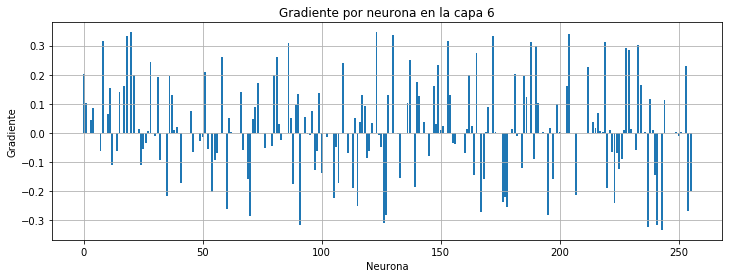

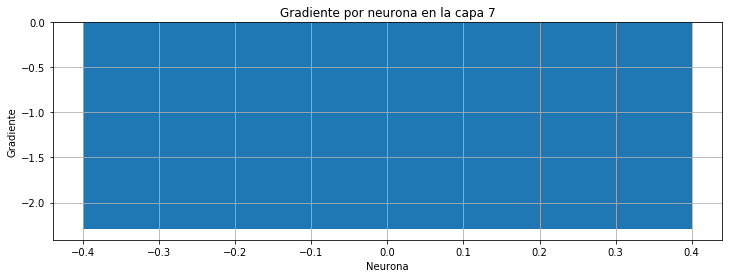

In [38]:
plot_gradients(evaluated_gradients[1],1)
plot_gradients(evaluated_gradients[3],2)
plot_gradients(evaluated_gradients[5],3)
plot_gradients(evaluated_gradients[7],4)
plot_gradients(evaluated_gradients[9],5)
plot_gradients(evaluated_gradients[11],6)

### f. Red modificada

Basandonos en la experiencia aprendida en los distintos casos en este punto se modifico la red para lograr una convergencia adecuada.

In [20]:
def define_model_f():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

In [21]:
model_f = define_model_f()
history_f = calculate_gradients(model_f)

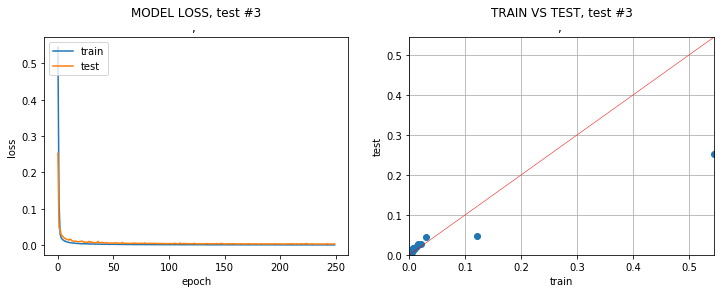

In [22]:
plot_chart(history_f)

### g. Red con Softplus

In [39]:
def define_model_g():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='softplus'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='softplus'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='softplus'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='softplus'))
    model.add(
        Dense(
            256,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='he_uniform',
            activation='softplus'))
    model.add(Dense(1, kernel_initializer='he_uniform', activation='linear'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

In [40]:
model_g = define_model_g()
history_g = calculate_gradients(model_g)

ValueError: Axis limits cannot be NaN or Inf

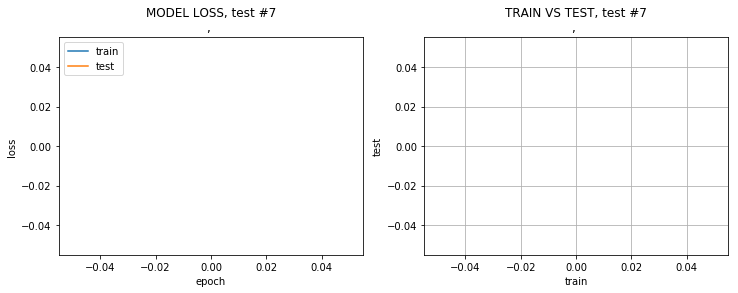

In [41]:
plot_chart(history_g)

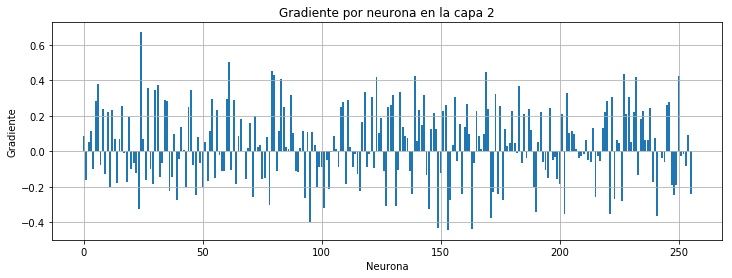

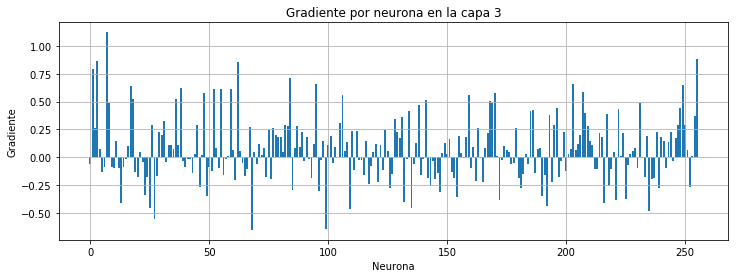

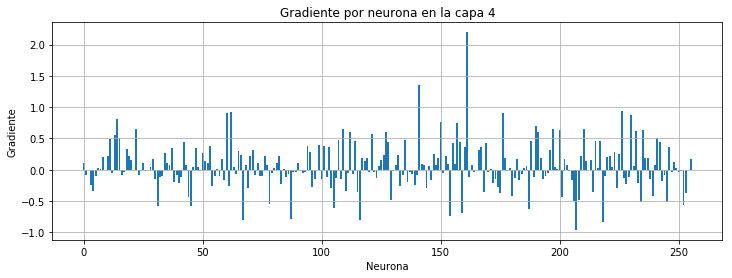

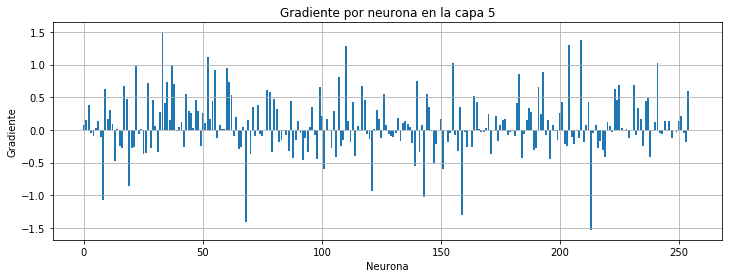

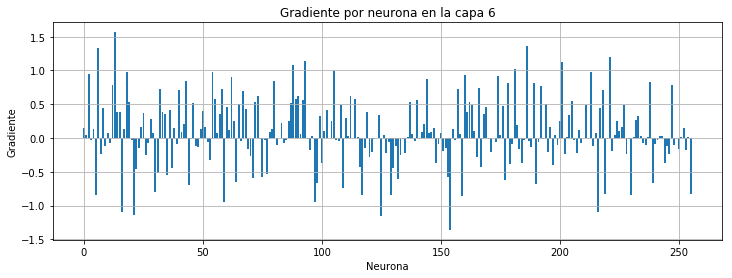

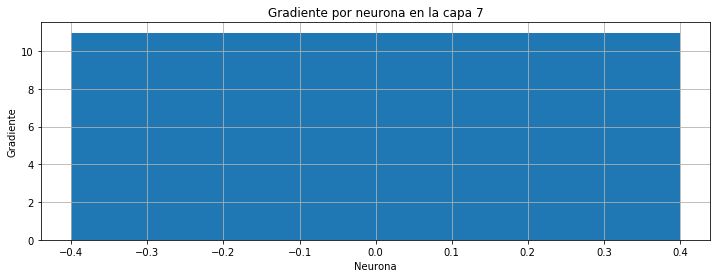

In [42]:
plot_gradients(evaluated_gradients[1],1)
plot_gradients(evaluated_gradients[3],2)
plot_gradients(evaluated_gradients[5],3)
plot_gradients(evaluated_gradients[7],4)
plot_gradients(evaluated_gradients[9],5)
plot_gradients(evaluated_gradients[11],6)

### h. red shallow

A continuacion se muestra que la red shallow diverge, principalmente por la cantidad de neuronas que estan influyendo sobre la capa de salida.

In [43]:
def define_model_h():
    global X_train_scaled
    global X_val_scaled
    global X_test_scaled
    global y_train_scaled
    global y_val_scaled
    global sgd
    model = Sequential()
    model.add(
        Dense(
            1024,
            input_dim=X_train_scaled.shape[1],
            kernel_initializer='uniform',
            activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    return (model)

In [44]:
model_h = define_model_h()
history_h = train_model(model_h)

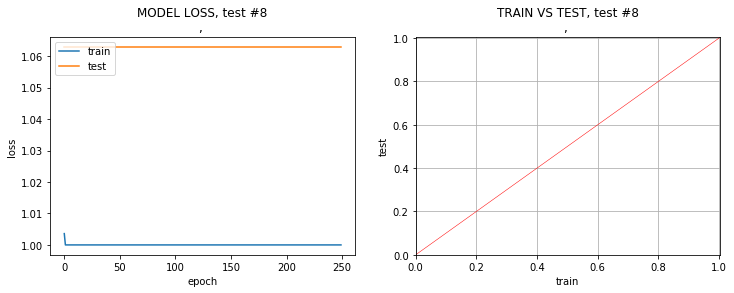

In [45]:
plot_chart(history_h)

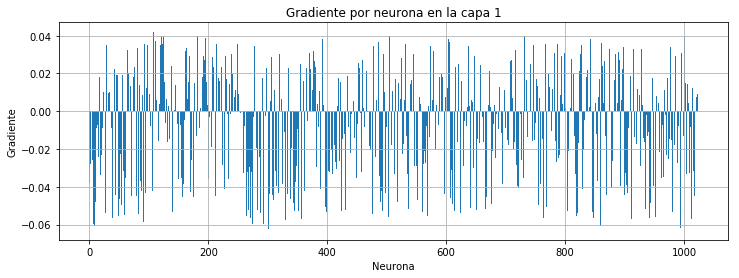

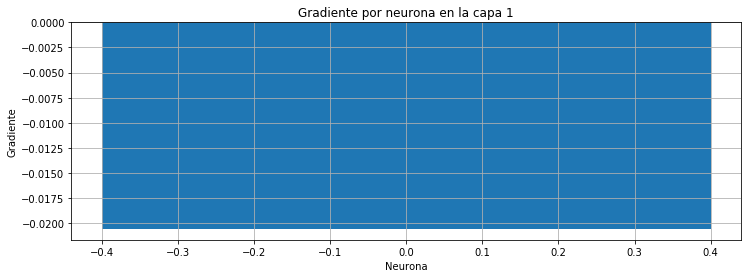

In [47]:
plot_gradients(model_h.get_weights()[2],0)
plot_gradients(model_h.get_weights()[3],0)